In [1]:
import numpy as np
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from matplotlib import pyplot
from keras.models import load_model

Using TensorFlow backend.


In [2]:
#define optimiser
opt = Adam(lr=0.0002, beta_1=0.5)
#load Model
g_model = load_model('g_model.h5')

D:\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
#Compile
g_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])

In [4]:
import librosa

In [5]:
audiofile = "5.wav"

In [6]:
audio,sr = librosa.load("combined_street/" + audiofile,16000)
n_fft = 511
hop_length_fft = 63
frame_length = 8064*2
chunk_mag = []
chunk_pha = []
i = 0
while (i+frame_length<len(audio)):
    stftaudio = librosa.stft(audio[i:i+frame_length], n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)
    chunk_mag.append(stftaudio_magnitude_db/80)
    chunk_pha.append(stftaudio_phase)
    i += frame_length


In [7]:
test_x = np.array(chunk_mag).reshape([len(chunk_mag),256,256,1])

In [8]:
pred_y = g_model.predict(test_x)

In [9]:
np.shape(pred_y)

(10, 256, 256, 1)

In [10]:
def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

In [11]:
def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

In [12]:
audio_denoise_recons = matrix_spectrogram_to_numpy_audio(pred_y[:,:,:,0]*80, np.array(chunk_pha), frame_length, hop_length_fft)
nb_samples = audio_denoise_recons.shape[0]
denoise_long = audio_denoise_recons.reshape(1, nb_samples * frame_length)*10

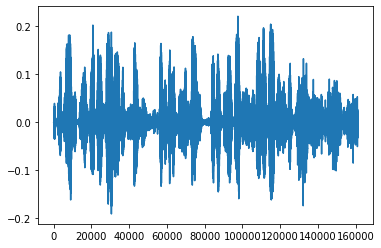

In [13]:
import matplotlib.pyplot as plt
plt.plot(denoise_long[0, :])

In [14]:
audio,sr = librosa.load("combined_street/" + audiofile,16000)

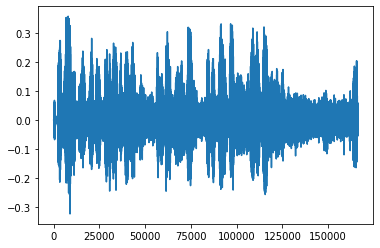

In [15]:
plt.plot(audio)

In [16]:
import IPython.display as ipd
ipd.Audio(data = denoise_long[0, :], rate = sr )

In [17]:
import IPython.display as ipd
ipd.Audio(data = audio, rate = sr )